In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

In [4]:

ROOT_FILE_PATH ="/Users/test/Downloads/archive/"
FEATURE_IMAGE_PATH= "list_attr_celeba.csv"
IMAGE_PATH = "img_align_celeba/img_align_celeba"

In [11]:
df = pd.read_csv(ROOT_FILE_PATH + FEATURE_IMAGE_PATH, usecols=['image_id','Male'])
df = df.sample(n=2500, random_state = 42).reset_index(drop=True)

In [12]:
df

,image_id,Male
0,093242.jpg,1
1,121414.jpg,-1
2,010625.jpg,1
3,082524.jpg,-1
4,073193.jpg,-1
...,...,...
2495,167758.jpg,-1
2496,069618.jpg,1
2497,139740.jpg,-1
2498,130472.jpg,-1


In [13]:
df["Gender"] = df["Male"].apply(lambda x: "Male" if x == 1 else "Female")

In [15]:
df.drop("Male", axis=1, inplace=True)

In [16]:
df.head()

,image_id,Gender
0,093242.jpg,Male
1,121414.jpg,Female
2,010625.jpg,Male
3,082524.jpg,Female
4,073193.jpg,Female


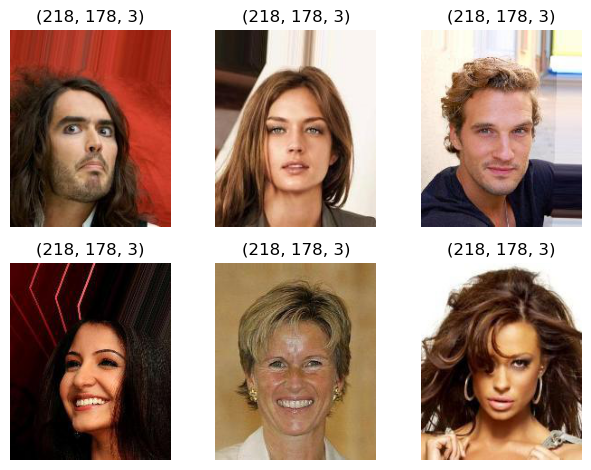

In [17]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    
    # Read an Image.
    img = cv2.imread(ROOT_FILE_PATH + IMAGE_PATH + "/"  + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [20]:
category_count = df["Gender"].value_counts()
print(category_count)

Gender
Female    1442
Male      1058
Name: count, dtype: int64
1442


In [19]:
higher_category = list(category_count.index)[0]
higher_category

'Female'

In [25]:
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")

<Axes: xlabel='Gender'>

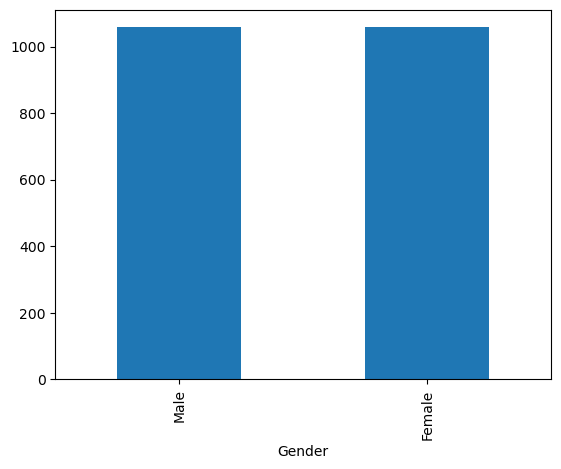

In [28]:
df["Gender"].value_counts().plot.bar()

In [29]:
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, validation_df = train_test_split(test_df, test_size=0.33)

In [30]:
IMAGE_SIZE = (218, 178)
BATCH_SIZE = 15

In [31]:
# Generate Train Images Data Generator.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    ROOT_FILE_PATH + IMAGE_PATH + "/", 
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1481 validated image filenames belonging to 2 classes.


In [34]:
# Generate Validation Images Data Generator.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    ROOT_FILE_PATH + IMAGE_PATH + "/", 
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 210 validated image filenames belonging to 2 classes.


In [35]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    ROOT_FILE_PATH + IMAGE_PATH + "/",  
    x_col='image_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 425 validated image filenames.


In [36]:
base_vgg_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape= IMAGE_SIZE + (3,))

80134624/80134624 [==============================] - 1s 0us/step


In [37]:
base_vgg_model.trainable = False
base_vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

In [38]:
vgg_model = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
]
)

In [39]:
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.001)
callbacks = [earlystop, learning_rate_reduction]

In [42]:
history = vgg_model.fit(train_generator, validation_data = validation_generator
                        , validation_steps=len(validation_df)//BATCH_SIZE
                        ,steps_per_epoch=len(train_df)//BATCH_SIZE,
                        epochs=10, verbose = 1, callbacks=callbacks)

Epoch 1/10


2024-03-24 13:02:53.167404: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/98 [==>...........................] - ETA: 2:13 - loss: 0.8651 - accuracy: 0.4600